## ML Supervisado: Regresiones - Tarea Individual

### Entrega 30/12 a correo marcelo.medel.v@gmail.com.

- (15%) Pregunta 1:
    - ¿Qué entiende del método de ajuste por mínimos cuadrados ordinarios (OLS)? Investigue y desarrolle.

- (15%) Pregunta 2:
    - ¿En qué casos puede ser útil medir el **MAPE** como métrica de error? En el código se le entrega el método para calcular la métrica.

- (70%) Pregunta 3:

    - Utilice los mismos datos y códigos del ejemplo a continuación, pero utilizando lo siguiente:
        * **X**: *Global_reactive_power, Voltage, Sub_metering_1, Sub_metering_2, Sub_metering_3*
        * **Y**: *Global Intensity*

    - **Preguntas**:

        * ¿Existen valores anormales en los datos (outliers)? ¿será necesario hacer algún tipo de tratamiento a estos datos?.
        * ¿Será necesario escalar los datos?, en caso de utilizar algún método de escalamiento (MinMax, Standard, Robust, otro), ¿mejora o empeora los resultados de los modelos?.
        * ¿Para qué sirve la métrica *explained variance*? El cálculo se encuentra en el código.
        * ¿Qué hiperparámetros de los modelos modificó para llegar a la mejor solución?
        * De los modelos que desarrolló ¿cuál es el que tiene mejor performance respecto a las métricas? interprete los resultados basándose en las métricas.
        * ¿Qué diferencias observa al mirar los coeficientes de cada modelo? Interprete cuales son las variables que mejor modelan el problema.



## Regression Example 

* Instale la última versión disponible de scikit learn. Para este ejemplo es necesaria la versión 1.5 para poder desarrollar la métrica RMSE.

* El ejercicio fue tomado de Kaggle: https://www.kaggle.com/akouaorsot/power-consumption-regression-rmse-0-04

### Explicación tomada de Kaggle.

#### Context

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

**Data Set Characteristics**:
Multivariate, Time-Series

**Associated Tasks**:
Regression, Clustering

Data Set Information:

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).

#### Notes:
1.**Power Consumption** : (globalactivepower *1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Attribute Information**:
1.**date**: Date in format dd/mm/yyyy

2.**time**: time in format hh:mm:ss

3.**globalactivepower**: household global minute-averaged active power (in kilowatt)

4.**globalreactivepower**: household global minute-averaged reactive power (in kilowatt)

5.**voltage**: minute-averaged voltage (in volt)

6.**global_intensity**: household global minute-averaged current intensity (in ampere)

7.**submetering1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.**submetering2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.**submetering3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [1680]:
# Instalamos las librerias necesarias
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [1681]:
import sklearn
print(sklearn.__version__)

1.6.0


In [1682]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.float_format", "{:.2f}".format)
sns.set(rc={'figure.figsize': (12,8)})


## Data Preprocessing

* Cargamos los datos
* Se reemplazan valores nulos o incorrectos con valor -1
* Se realiza cambio de tipo de datos para las variables numéricas
* Se realiza una imputación de los valores -1 por la media de los valores

In [1683]:
%%time
url = 'https://drive.google.com/file/d/1G2JpK7urCs5lYcoeGMyXJxR_1FCIoTZC/view?usp=drive_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path, sep=";", encoding="ISO-8859-1", header=0, compression='zip')
df.head()

CPU times: total: 953 ms
Wall time: 5.38 s


<timed exec>:3: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.00
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.00
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.00
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.00
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.00


In [1684]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [1685]:
# Feature Modification
from sklearn.impute import SimpleImputer

df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)
df.replace(['?', 'nan', np.nan], -1, inplace=True) 
num_vars= ['Global_active_power', 'Global_reactive_power', 'Voltage', 
           'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for i in num_vars:
    df[i] = pd.to_numeric(df[i])
imp = SimpleImputer(missing_values=-1, strategy='mean')
df[num_vars] = imp.fit_transform(df[num_vars])

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.22,0.42,234.84,18.40,0.00,1.00,17.00
1,16/12/2006,17:25:00,5.36,0.44,233.63,23.00,0.00,1.00,16.00
2,16/12/2006,17:26:00,5.37,0.50,233.29,23.00,0.00,2.00,17.00
3,16/12/2006,17:27:00,5.39,0.50,233.74,23.00,0.00,1.00,17.00
4,16/12/2006,17:28:00,3.67,0.53,235.68,15.80,0.00,1.00,17.00


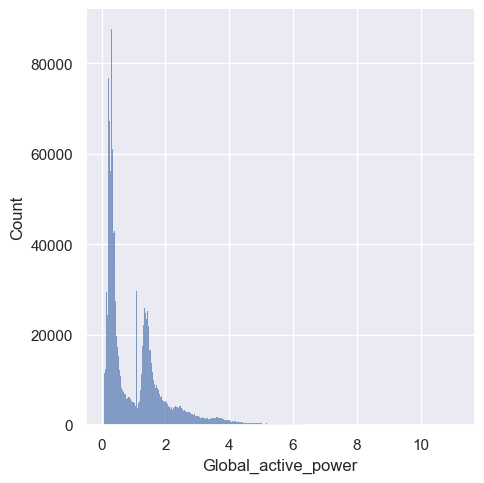

CPU times: total: 500 ms
Wall time: 1.33 s


In [1686]:
%%time
# Distribution of the target variables
sns.displot(data=df, x='Global_active_power')
plt.show()

In [1687]:
# Excluir la columna de fechas del cálculo de la correlación
df_corr = df.drop(columns=['Date', 'Time'])


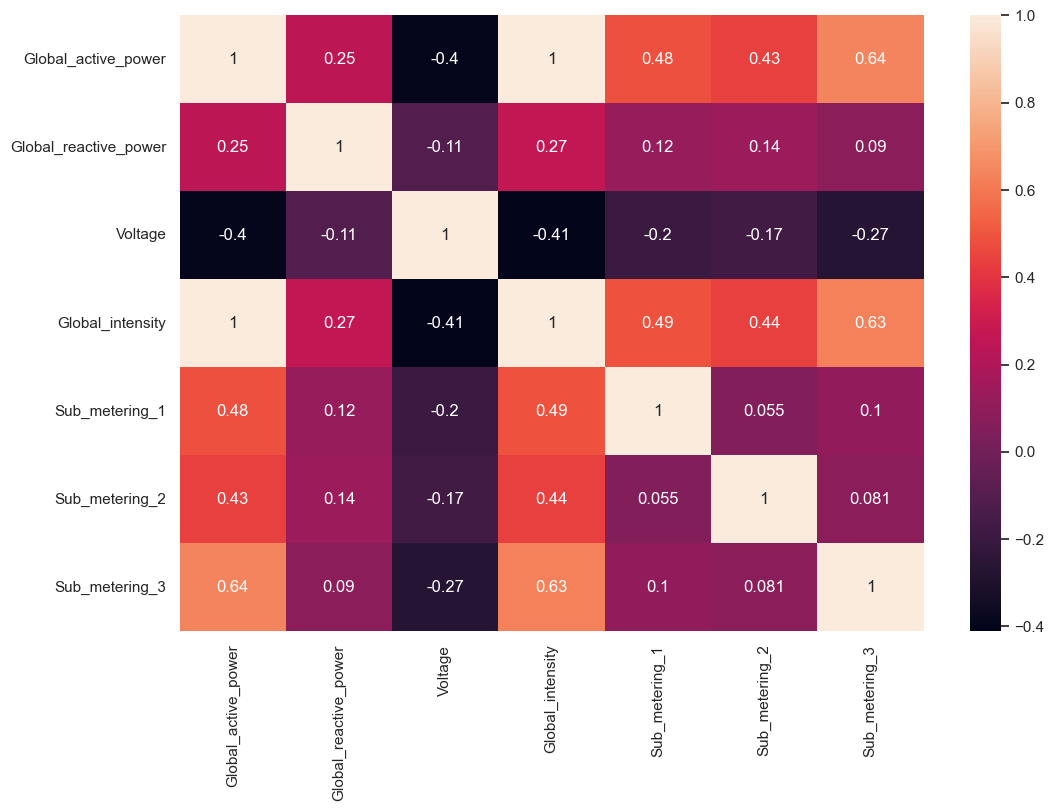

CPU times: total: 328 ms
Wall time: 887 ms


In [1688]:
%%time
corr = np.corrcoef(df_corr.corr())
sns.heatmap(df_corr.corr(), annot=True)
plt.show()

### Train / test split process

* Para poder entrenar el modelo se dividen los datos en entrenamiento (70%) y test (30%).
* Se definen las variables independientes (**X**): *Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3*
* Se define la variable dependiente (**Y**): *Global_active_power*.

In [1689]:
from sklearn.model_selection import train_test_split

cols = ['Global_reactive_power','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3']
X = df[cols].values
Y = df['Global_intensity'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 13)

### Métricas
* Para medir la performance de nuestro modelo utilizaremos las siguientes métricas:
    * Mean Absolute Error (**MAE**)
    * Mean Squared Error (**RMSE**)
    * Root Mean Squared Error: (**RMSE**)
    * R2
    * Explained variance

In [1690]:
### Metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,explained_variance_score, mean_absolute_percentage_error, root_mean_squared_error

def get_metrics(Y_test,pred):
    mae = round(mean_absolute_error(Y_test,pred),3)
    mse = round(mean_squared_error(Y_test, pred), 3)
    rmse = round(root_mean_squared_error(Y_test, pred), 3)
    mape = round(mean_absolute_percentage_error(Y_test, pred), 3)
    r2 = round(r2_score(Y_test,pred), 4)
    ev = round(explained_variance_score(Y_test,pred), 4)
    return {'mae':mae,'mse':mse,'rmse':rmse, 'mape':mape,'r2':r2,'ev':ev}

### Modelos

Se desarrollan los modelos de regresión lineal, regularización de Ridge, regularización de Lasso, Elastic Net y Decision Tree.

Adicionalmente se desarrollan los modelos con Cross Validation para Elastic Net, Ridge y Lasso.

In [1691]:
### variables para guardar información relevante de los modelos
models = {}
coefs = {}

#### Linear Regression

In [1692]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
reg_model.fit(X_train,Y_train)
pred = reg_model.predict(X_test)
models['linear'] = get_metrics(Y_test,pred)
coefs['linear'] = reg_model.coef_

CPU times: total: 93.8 ms
Wall time: 297 ms


#### Ridge Regression

In [1693]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.linear_model import Ridge

alpha = 0.5
ridge_model = Ridge(alpha=alpha, random_state=13)
ridge_model.fit(X_train,Y_train)
pred = ridge_model.predict(X_test)
models['ridge'] = get_metrics(Y_test,pred)
coefs['ridge'] = ridge_model.coef_

CPU times: total: 15.6 ms
Wall time: 187 ms


#### Ridge Cross Validation

In [1694]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV
from sklearn.linear_model import RidgeCV

alphas = [0.1, 0.5, 0.8]
ridgeCV_model = RidgeCV(alphas=alphas)
ridgeCV_model.fit(X_train,Y_train)
pred = ridgeCV_model.predict(X_test)
models['ridgeCV'] = get_metrics(Y_test,pred)
coefs['ridgeCV'] = ridgeCV_model.coef_

CPU times: total: 422 ms
Wall time: 673 ms


#### Lasso Regression

In [1695]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
from sklearn.linear_model import Lasso

alpha = 0.5
lasso_model = Lasso(alpha=alpha, random_state=13)
lasso_model.fit(X_train, Y_train)
pred = lasso_model.predict(X_test)
models['lasso'] = get_metrics(Y_test,pred)
coefs['lasso'] = lasso_model.coef_

CPU times: total: 141 ms
Wall time: 266 ms


#### Lasso Cross Validation 

In [1696]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV
from sklearn.linear_model import LassoCV

alphas = [0.1, 0.5, 0.8]
lassoCV_model = LassoCV(alphas=alphas, random_state=13)
lassoCV_model.fit(X_train, Y_train)
pred = lassoCV_model.predict(X_test)
models['lassoCV'] = get_metrics(Y_test,pred)
coefs['lassoCV'] = lassoCV_model.coef_

CPU times: total: 641 ms
Wall time: 1.39 s


## Ridge vs Lasso

* Lasso consigue seleccionar predictores, es decir convierte a cero la importancia de un feature, en cambio Ridge considera todo, dando menos peso a los menos importantes.
* Lasso tiene ventaja en escenarios donde no todos los predictores son importantes para el modelo y se desea que los **menos influyentes queden excluidos**.
* Por otro lado, **cuando existen predictores altamente correlacionados linealmente, Ridge reduce la influencia de todos ellos a la vez y de forma proporcional**, **mientras que Lasso tiende a seleccionar uno de ellos, dándole todo el peso y excluyendo al resto.** En presencia de correlaciones, esta selección varía mucho con pequeñas perturbaciones (cambios en los datos de entrenamiento), por lo que, las soluciones de Lasso son muy inestables si los predictores están altamente correlacionados.
* Para conseguir un equilibrio óptimo entre estas dos propiedades, se puede emplear lo que se conoce como penalización Elastic Net, que combina ambas estrategias.

#### Elastic Net

In [1697]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elastic%20net#sklearn.linear_model.ElasticNet
from sklearn.linear_model import ElasticNet

elastic_model = ElasticNet(random_state=13)
elastic_model.fit(X_train, Y_train)
pred = elastic_model.predict(X_test)
models['elastic'] = get_metrics(Y_test,pred)
coefs['elastic'] = elastic_model.coef_

CPU times: total: 1.64 s
Wall time: 573 ms


#### Elastic Net CV

In [1698]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV
from sklearn.linear_model import ElasticNetCV

elasticCV_model = ElasticNetCV(random_state=13)
elasticCV_model.fit(X_train, Y_train)
pred = elasticCV_model.predict(X_test)
models['elasticCV'] = get_metrics(Y_test,pred)
coefs['elasticCV'] = elasticCV_model.coef_

CPU times: total: 3.22 s
Wall time: 3.62 s


#### Decision Tree

In [1699]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=0)
tree_model = tree_model.fit(X_train, Y_train)
pred = tree_model.predict(X_test)
models['decision_tree'] = get_metrics(Y_test,pred)

CPU times: total: 2.56 s
Wall time: 6.61 s


### Verificación de resultados de los modelos

In [1700]:
df_coef = pd.DataFrame.from_dict(coefs,orient='index',columns=cols).reset_index()
df_metrics = pd.DataFrame.from_dict(models)

In [1701]:
df_metrics

,linear,ridge,ridgeCV,lasso,lassoCV,elastic,elasticCV,decision_tree
mae,1.52,1.52,1.52,1.56,1.56,1.57,1.55,1.61
mse,5.05,5.05,5.05,5.32,5.29,5.33,5.21,7.30
rmse,2.25,2.25,2.25,2.31,2.30,2.31,2.28,2.70
mape,0.56,0.56,0.56,0.63,0.62,0.64,0.61,0.54
r2,0.74,0.74,0.74,0.73,0.73,0.73,0.73,0.63
ev,0.74,0.74,0.74,0.73,0.73,0.73,0.73,0.63


In [1702]:
df_metrics_1 = df_metrics.copy()

In [1703]:
df_coef

,index,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,linear,4.37,-0.18,0.27,0.26,0.27
1,ridge,4.37,-0.18,0.27,0.26,0.27
2,ridgeCV,4.37,-0.18,0.27,0.26,0.27
3,lasso,0.00,-0.15,0.27,0.26,0.27
4,lassoCV,0.00,-0.18,0.28,0.27,0.27
5,elastic,0.00,-0.14,0.27,0.26,0.27
6,elasticCV,0.84,-0.18,0.28,0.27,0.27


In [1704]:
importance = tree_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.07641
Feature: 1, Score: 0.11057
Feature: 2, Score: 0.20018
Feature: 3, Score: 0.15676
Feature: 4, Score: 0.45607


### RESOLUCIÓN DE TAREA

- (15%) Pregunta 1:
    - ¿Qué entiende del método de ajuste por mínimos cuadrados ordinarios (OLS)? Investigue y desarrolle.

- RESPUESTA:

El método de ajuste por minimos cuadrados ordinarios es una técnica estadística utilizada para encontrar la relación lineal que mejor ajusta un conjunto de datos. En términos simples, el objetivo del OLS es minimizar la suma de los cuadrados de las diferencias entre los valores observados (reales) y los valores predichos por el modelo. Estas diferencias se conocen como residuos. En resumen, es un método para estimar los parámetros desconocidos en un modelo de regresión lineal. El objetivo es encontrar la línea (o hiperplano en dimensiones superiores) que mejor se ajuste a los datos minimizando la suma de las diferencias al cuadrado entre los valores observados y los valores predichos por el modelo.


En el caso de un modelo de regresión lineal simple, se asume que la relación entre las variables puede expresarse como:

y=β0+β1x1+ϵ

Para un modelo de regresión lineal múltiple, la relación es:

y=β0+β1x1+β2x2+⋯+βnxn+ϵ

Donde:
y: Variable dependiente o respuesta.
x1: Variables independientes (predictoras).
β0: Intercepto del modelo (valor de 𝑦 y cuando todas las 𝑥 𝑖 x i  son 0).
β1: Coeficientes de las variables independientes que representan el impacto de cada 𝑥 𝑖 x i sobre 𝑦 y.
ϵ: Término de error o residuo.

El método OLS busca minimizar la suma de los cuadrados de los residuos:

SSE=i=1∑n(yi−y^z)2

Donde:
yi: Valores observados de la variable dependiente.
y^z: Valores predichos por el modelo.

* Ejemplo y Desarrollo:
Dado que estamos usando sklearn a continuación se muestra un ejemplo donde  la clase LinearRegression de scikit-learn aplica automáticamente OLS para encontrar la pendiente e intercepto que minimizan la suma de los errores cuadráticos (o residuos) entre las predicciones y los valores observados.

Este es un ajuste clásico de regresión lineal, donde el modelo encuentra los coeficientes (pendiente e intercepto) que minimizan la función de error cuadrático medio (MSE), que es justamente el objetivo del método de OLS.


Coeficiente de regresión (pendiente): 2.97
Intercepto: 2.11
Error cuadrático medio (MSE): 0.248
Coeficiente de determinación (R²): 0.7470


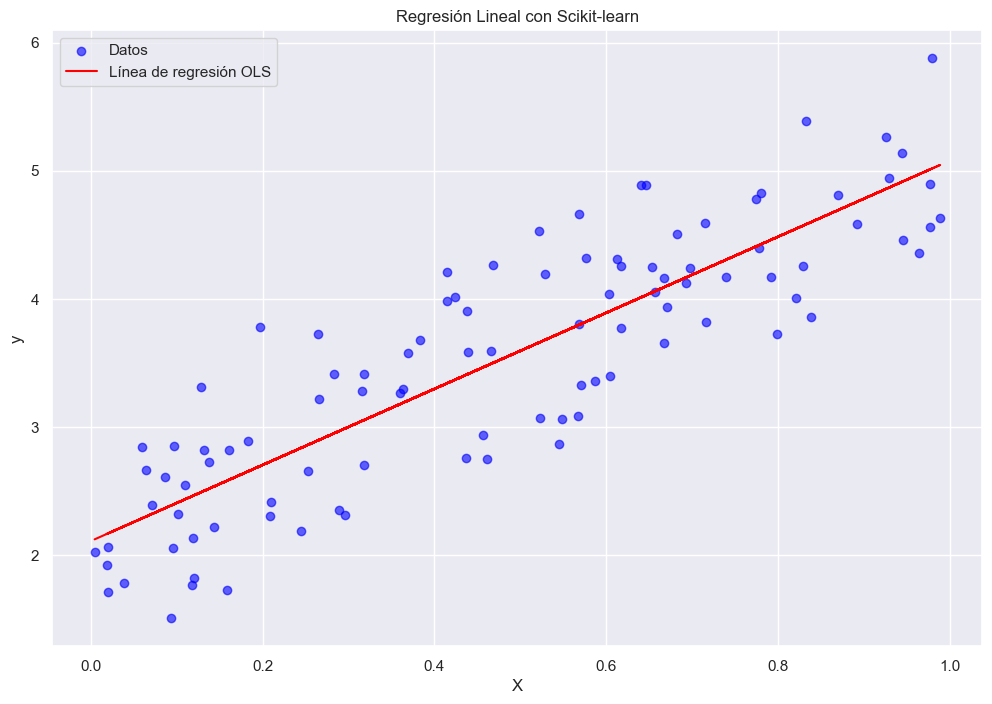

In [1705]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Conjunto de datos de ejemplo
np.random.seed(0)
X = np.random.rand(100, 1)  # Variable independiente
y = 3 * X.squeeze() + 2 + np.random.randn(100) * 0.5  # Variable dependiente

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predecir los valores
y_pred = model.predict(X)

# Coeficientes del modelo
print(f"Coeficiente de regresión (pendiente): {model.coef_[0]:.2f}")
print(f"Intercepto: {model.intercept_:.2f}")
print(f"Error cuadrático medio (MSE): {mean_squared_error(y, y_pred):.3f}")
print(f"Coeficiente de determinación (R²): {r2_score(y, y_pred):.4f}")

# Graficar los datos y la línea de regresión
plt.scatter(X, y, label='Datos', color='blue', alpha=0.6)
plt.plot(X, y_pred, color='red', label='Línea de regresión OLS')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Regresión Lineal con Scikit-learn')
plt.show()


* Resultado:

El resultado de model.coef_ y model.intercept_ corresponde a la pendiente y el intercepto de la recta ajustada, y el valor de R² te indica qué tan bien se ajusta el modelo a los datos.

Para entender estos resultados desde la perspectiva del ajuste por Mínimos Cuadrados Ordinarios (OLS), es importante recordar que el objetivo de este metodo es encontrar los valores de los coeficientes (pendiente e intercepto) de la recta de regresión que minimicen la suma de los errores cuadráticos entre las predicciones del modelo y los valores observados.

* El valor de la pendiente 𝛽1=2.97 indica que, por cada unidad de aumento en 𝑋, el modelo predice un aumento de aproximadamente 2.97 unidades en 𝑦. Este es el resultado de ajustar la línea de tal manera que el error cuadrático (yi−y^z)2 se minimice globalmente.

* El intercepto 𝛽0 = 2.11 es el valor en el que la recta de regresión corta el eje 𝑦. Este valor tambin se obtiene a través de OLS, y es la estimación de 𝑦 cuando X=0. OLS ajusta el modelo para que esta constante sea tal que, cuando el valor de 𝑋 es 0, la estimación de 𝑦  sea la mas cercana posible a los valores observados.

* En el contexto de OLS, el método busca minimizar la suma de los cuadrados de estos residuos. Un MSE bajo 0.248 como del ejemplo  indica que las prediciones del modelo están bastante cerca de los valores observados, aunque no son perfectas. El objetivo de OLS es encontrar los coeficientes de manera que el MSE sea lo mas bajo posible.

* El R² indica la proporción de la variabilidad de 𝑦 explicada por el modelo, lo cual también es un reflejo de cuán efectivo ha sido el ajuste OLS. Un valor de R² de 0.74 significa que el 74.7% de la variabilidad en los valores de 𝑦 y se puede explicar a través del modelo lineal. El resto (25.3%) se debe a factores que no son capturados por la regresion, es decir, el error residual.

- (15%) Pregunta 2:
¿En qué casos puede ser útil medir el **MAPE** como métrica de error? En el código se le entrega el método para calcular la métrica.

- RESPUESTA:

Medir el MAPE como métrica de error puede ser útil en los siguientes casos:

* 1-Interpretabilidad porcentual:

El MAPE es útil cuando queremos expresar el error en porcentajes, lo que facilita la comprensión, especialmente para audiencias no técnicas. Por ejemplo, en este ejercicio, si se evalúa la variable Global Intensity (en amperios), un error promedio de x %  resulta mas facil de interpretar que un valor absoluto en amperios. Esto permite que los resultados del modelo sean más accesibles para quienes no están familiarizados con las unidades técnicas.

* 2-Comparación entre diferentes conjuntos de datos o modelos:

Al ser una metrica adimensional, es especialmente útil para comparar el rendimiento de diferentes modelos o conjuntos de datos. En este caso, si se aplican modelos con la misma entrada pero diferentes variables objetivo (por ejemplo, Global Intensity y Power Consunption), el MAPE permite una comparación justa, siempre y cuando los valores reales sean positivos y suficientemente grandes.

* 3-Evaluación en problemas donde los errores relativos son críticos:

En situaciones donde los errores relativos son más importantes que los absolutos, el MAPE es una métrica clave. Por ejemplo, al predecir el consumo energético (Power Consumption), un error porcentual tiene mayor relevancia para la planificación que un error absoluto, ya que las decisiones estratégicas suelen depender de la precisión relativa en lugar de valores absolutos.

* 4-Toma de decisiones basada en precisión relativa:

En casos donde las decisiones dependen de la relación entre la predicción y los valores reales. Por ejemplo, en este ejercicio, al analizar variables como Global Active Power, un error porcentual brinda información directa sobre el impacto relativo en el consumo energético, lo que es crucial para análisis financieros o de costos.

- (70%) Pregunta 3:

    - Utilice los mismos datos y códigos del ejemplo a continuación, pero utilizando lo siguiente:
        * **X**: *Global_reactive_power, Voltage, Sub_metering_1, Sub_metering_2, Sub_metering_3*
        * **Y**: *Global Intensity*

    - **Preguntas**:

        * ¿Existen valores anormales en los datos (outliers)? ¿será necesario hacer algún tipo de tratamiento a estos datos?.
        * ¿Será necesario escalar los datos?, en caso de utilizar algún método de escalamiento (MinMax, Standard, Robust, otro), ¿mejora o empeora los resultados de los modelos?.
        * ¿Para qué sirve la métrica *explained variance*? El cálculo se encuentra en el código.
        * ¿Qué hiperparámetros de los modelos modificó para llegar a la mejor solución?
        * De los modelos que desarrolló ¿cuál es el que tiene mejor performance respecto a las métricas? interprete los resultados basándose en las métricas.
        * ¿Qué diferencias observa al mirar los coeficientes de cada modelo? Interprete cuales son las variables que mejor modelan el problema.

* ¿Existen valores anormales en los datos (outliers)? ¿será necesario hacer algún tipo de tratamiento a estos datos?.

# RESPUESTA:

* Identificación de Outliers: Lo primero que tenemos que hacer es evaluar si el conjunto de datos, tanto las variables predictoras como la variable de salida (dependiente), contienen outliers. Para ello, utilizamos gráficos como los boxplots para detectar valores que se encuentran fuera del rango intercuartílico (es decir, fuera de los límites definidos por Q1 - 1.5IQR y Q3 + 1.5IQR). Además, los histogramas pueden proporcionarnos una visualización adicional para observar la distribución de las variables y la presencia de valores extremos.

* Evaluación del dataset: Como primer paso, es importante también verificar que no haya valores nulos en las variables, lo cual se trata generalmente al inicio del proceso (como se realizó en el notebook).

* Tratamiento de Outliers: La necesidad de tratar los outliers depende del impacto que tengan sobre el modelo. Si los valores extremos afectan la precisión o el ajuste del modelo, por ejemplo, , la regresión lineal es sensible a los outliers, por lo que debemos tratar los valores anómalos antes de entrenar el modelo, sin embargo, Ridge regression es más robusta que la regresión lineal estándar, ya que utiliza regularización, lo que reduce la magnitud de los coeficientes. Aunque no es tan sensible a los outliers como la regresión lineal simple.

* Aunque Ridge y Elastic Net son menos sensibles a los outliers gracias a la regularización, lo mas recomendable seria tratarlos antes de entrenar los modelos (especialmente para Lasso y regresion lineal). Algunas de las técnicas que podemos aplicar son:

* 1.Eliminación de Outliers: Utilizando los límites definidos por el IQR o puntaje Z, podemos eliminar los valores que estén fuera del rango aceptable.
* 2.Imputación de Outliers: En lugar de eliminar los valores, podemos sustituir los outliers por la mediana o el percentil más cercano dentro del rango aceptable. Esto es útil para preservar la mayor cantidad de datos posible sin perder información relevante.
* 3-Tratamiento Individualizado: En algunos casos, puede ser útil investigar cada caso extremo manualmente para determinar si debe eliminarse o ajustarse según el contexto. Esto puede implicar la revisión de casos específicos en el dataset, especialmente si no se tiene información técnica detallada.
* 4-Cálculo del Puntaje Z: Se calcula el puntaje Z para cada dato. Si el puntaje Z es mayor a 3 o menor a -3, se considera un outlier. Este método estadístico es útil para identificar valores extremos que podrían estar afectando el modelo.
* 5-Transformación Logarítmica o Raíz Cuadrada: Si las variables tienen una distribución sesgada, aplicar una transformación logarítmica o una raíz cuadrada puede reducir el impacto de los outliers al "comprimir" los valores extremos.
* 6-Clipping o Winsorizing: Esta técnica implica recortar los valores extremos, asignándoles un valor máximo o mínimo razonable para evitar que influencien demasiado el modelo, manteniendo la distribución general sin perder demasiada variabilidad.

* Consideraciones Técnicas: Aunque los outliers deben tratarse utilizando métodos estadísticos, como los mencionados anteriormente, es importante tener en cuenta el conocimiento técnico del dominio. En este caso, aunque los outliers pueden ser detectados con métodos estadísticos, no siempre son errores. Pueden ser eventos legítimos (por ejemplo, un pico de consumo eléctrico durante un evento inusual). Por lo tanto, siempre es recomendable consultar con expertos o tener un conocimiento del contexto para validar si esos outliers son realmente anómalos o si representan eventos significativos en el dataset.



# Análisis de Datos y Tratamiento de outliers

In [1706]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00
mean,1.09,0.12,240.84,4.63,1.12,1.30,6.46
std,1.05,0.11,3.22,4.42,6.11,5.79,8.38
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00
25%,0.31,0.05,239.02,1.40,0.00,0.00,0.00
50%,0.63,0.10,240.96,2.80,0.00,0.00,1.00
75%,1.52,0.19,242.86,6.40,0.00,1.00,17.00
max,11.12,1.39,254.15,48.40,88.00,80.00,31.00


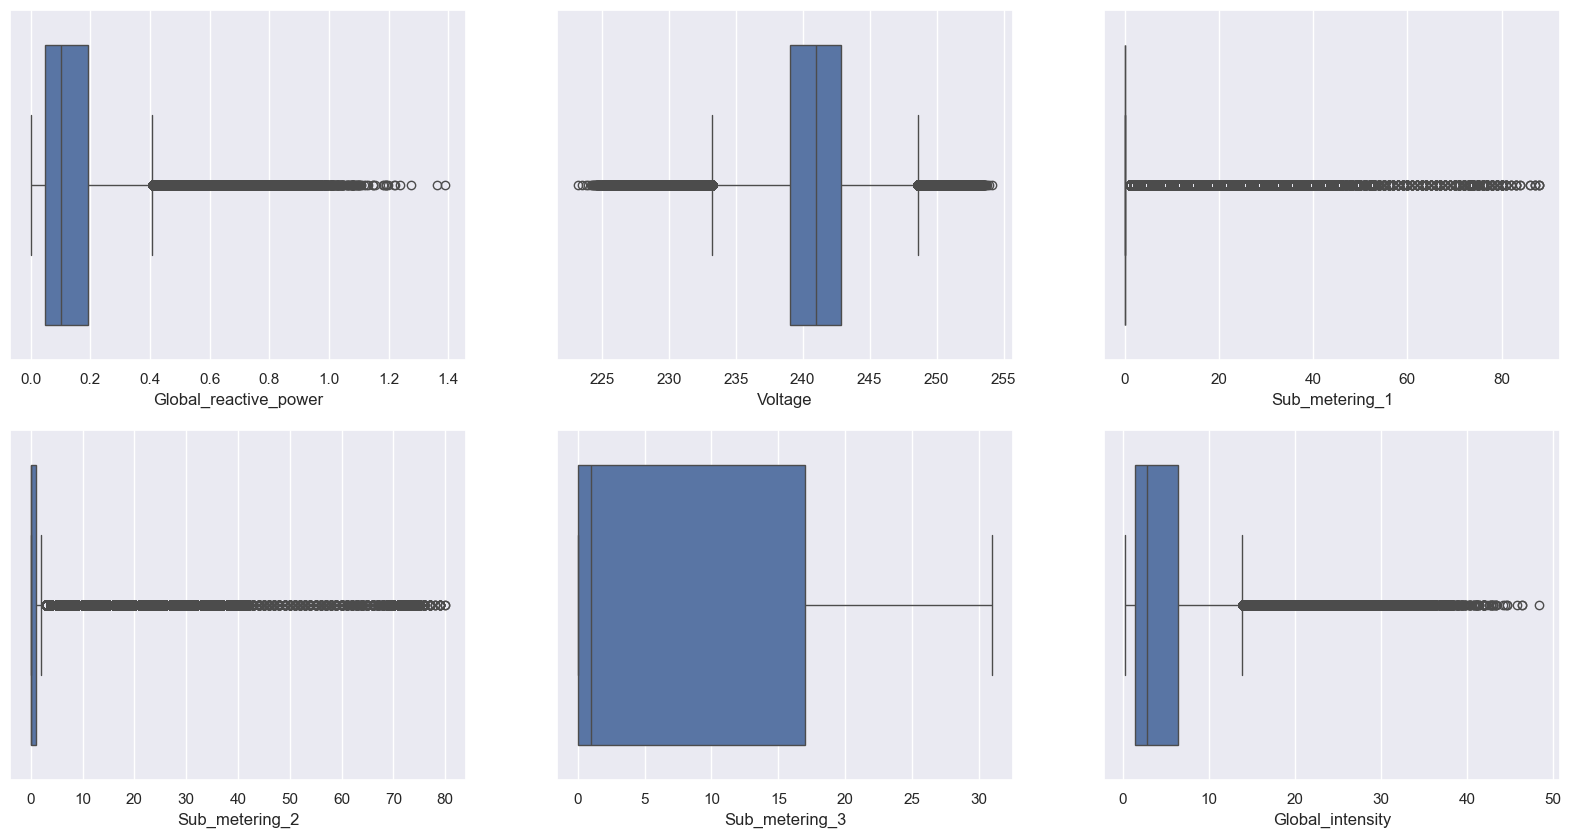

In [1707]:
# comprueba si existe outliers en las variables, Global_reactive_power, Voltage, Sub_metering_1, Sub_metering_2, Sub_metering_3 y Global Intensity
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
sns.boxplot(data=df, x='Global_reactive_power', ax=axs[0, 0])
sns.boxplot(data=df, x='Voltage', ax=axs[0, 1])
sns.boxplot(data=df, x='Sub_metering_1', ax=axs[0, 2])
sns.boxplot(data=df, x='Sub_metering_2', ax=axs[1, 0])
sns.boxplot(data=df, x='Sub_metering_3', ax=axs[1, 1])
sns.boxplot(data=df, x='Global_intensity', ax=axs[1, 2])
plt.show()

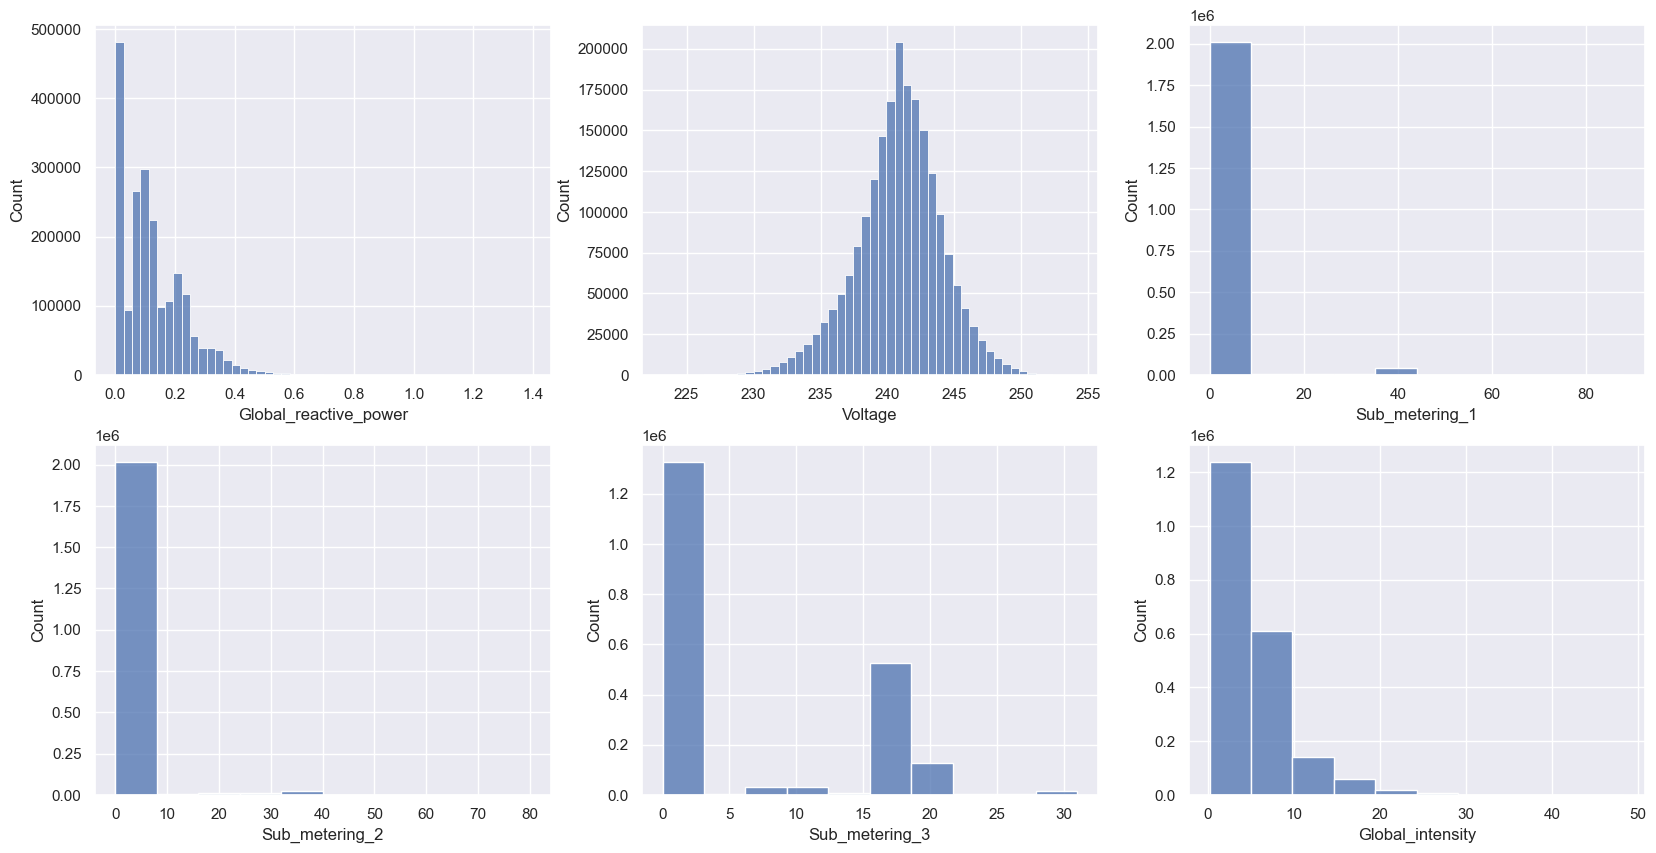

In [1708]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
sns.histplot(data=df, x='Global_reactive_power', bins=50, ax=axs[0, 0])
sns.histplot(data=df, x='Voltage',bins=50, ax=axs[0, 1])
sns.histplot(data=df, x='Sub_metering_1', bins=10, ax=axs[0, 2])
sns.histplot(data=df, x='Sub_metering_2', bins=10, ax=axs[1, 0])
sns.histplot(data=df, x='Sub_metering_3', bins=10, ax=axs[1, 1])
sns.histplot(data=df, x='Global_intensity', bins=10, ax=axs[1, 2])

plt.show()

In [1709]:
# Calcular IQC Max y Minimo para las variables Global_reactive_power, Voltage, Sub_metering_1, Sub_metering_2, Sub_metering_3 y Global Intensity
def iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    min_value = max(0, Q1 - 1.5 * IQR)  # Asegura que el mínimo no sea menor que 0
    max_value = Q3 + 1.5 * IQR
    return min_value, max_value


In [1710]:
min_value, max_value = iqr_outliers(df, 'Sub_metering_1')
print(f' Min: {min_value}, Max: {max_value}')

min_value, max_value = iqr_outliers(df, 'Sub_metering_2')
print(f' Min: {min_value}, Max: {max_value}')

min_value, max_value = iqr_outliers(df, 'Sub_metering_3')
print(f' Min: {min_value}, Max: {max_value}')

 Min: 0, Max: 0.0
 Min: 0, Max: 2.5
 Min: 0, Max: 42.5


 * Como podemos observar en la columna "Sub_metering_1" en este caso no tendriamos tratamiento efectivo de outliers si el rango intercuartil (IQR) resulta en límites de min_value y max_value iguales a 0.0. Esto ocurre porque los datos están altamente sesgados hacia ceros, y el cálculo de IQR (basado en los percentiles 25% y 75%) no captura valores significativos que se puedan considerar como "atípicos".


* Sub_metering_1:

Percentiles (25%, 50%, 75%): Todos están en 0.0, indicando que la mayoría de los valores son ceros.
Esto resulta en un IQR = 0, lo que hace que el tratamiento de outliers basado en IQR no funcione.


* Dado lo anterior consideramos solo limpiar el dataframe de los valores outliers los que no estan sesgados por 0 como ,Sub_metering_2, Sub_metering_3 Global_reactive_power,Voltage y Global_intensity

In [1711]:
df2 = df.copy()

In [1712]:
min_value, max_value = iqr_outliers(df2, 'Sub_metering_2')
print(f' Min: {min_value}, Max: {max_value}')

 Min: 0, Max: 2.5


In [1713]:
# Actualiza el df2 para filtrarlo eliminado los valores atípicos min_value y max_value
df2 = df2[(df2['Sub_metering_2'] >= min_value) & (df2['Sub_metering_2'] <= max_value)]

In [1714]:
min_value, max_value = iqr_outliers(df2, 'Sub_metering_3')
print(f' Min: {min_value}, Max: {max_value}')

 Min: 0, Max: 42.5


In [1715]:
# Actualiza el df2 para filtrarlo eliminado los valores atípicos min_value y max_value
df2 = df2[(df2['Sub_metering_3'] >= min_value) & (df2['Sub_metering_3'] <= max_value)]

In [1716]:
min_value, max_value = iqr_outliers(df2, 'Global_reactive_power')
print(f' Min: {min_value}, Max: {max_value}')

 Min: 0, Max: 0.398


In [1717]:
# Actualiza el df2 para filtrarlo eliminado los valores atípicos min_value y max_value
df2 = df2[(df2['Global_reactive_power'] >= min_value) & (df2['Global_reactive_power'] <= max_value)]

In [1718]:
min_value, max_value = iqr_outliers(df2, 'Voltage')
print(f' Min: {min_value}, Max: {max_value}')

 Min: 233.565, Max: 248.565


In [1719]:
# Actualiza el df2 para filtrarlo eliminado los valores atípicos min_value y max_value
df2 = df2[(df2['Voltage'] >= min_value) & (df2['Voltage'] <= max_value)]

In [1720]:
min_value, max_value = iqr_outliers(df2, 'Global_intensity')
print(f' Min: {min_value}, Max: {max_value}')

 Min: 0, Max: 12.899999999999999


In [1721]:
#Actualiza el df2 para filtrarlo eliminado los valores atípicos min_value y max_value
df2 = df2[(df2['Global_intensity'] >= min_value) & (df2['Global_intensity'] <= max_value)]

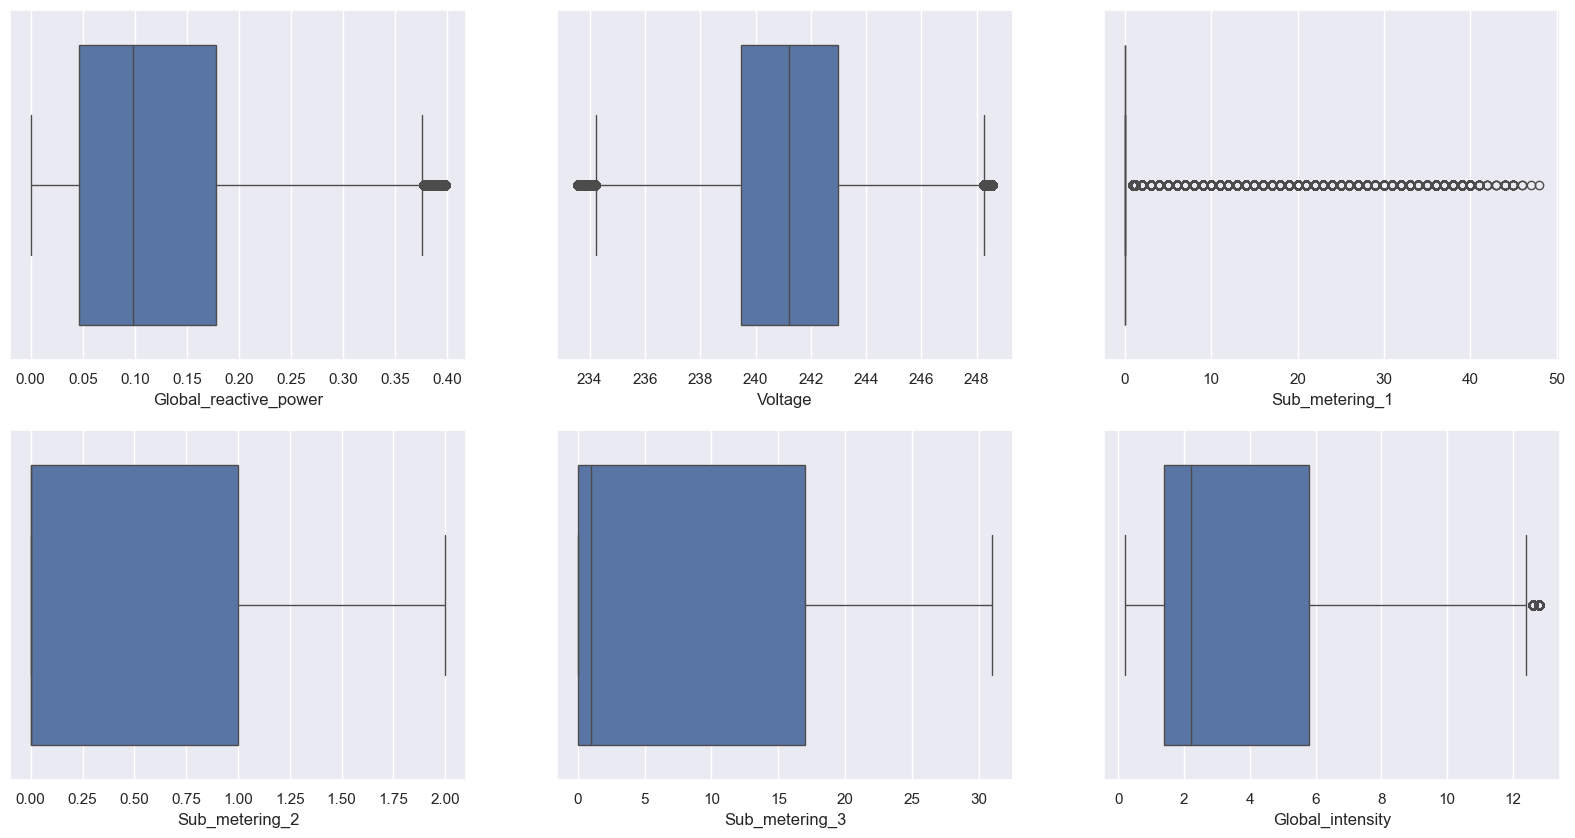

In [1722]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
sns.boxplot(data=df2, x='Global_reactive_power', ax=axs[0, 0])
sns.boxplot(data=df2, x='Voltage', ax=axs[0, 1])
sns.boxplot(data=df2, x='Sub_metering_1', ax=axs[0, 2])
sns.boxplot(data=df2, x='Sub_metering_2', ax=axs[1, 0])
sns.boxplot(data=df2, x='Sub_metering_3', ax=axs[1, 1])
sns.boxplot(data=df2, x='Global_intensity', ax=axs[1, 2])
plt.show()

In [1723]:
df2.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1839826.00,1839826.00,1839826.00,1839826.00,1839826.00,1839826.00,1839826.00
mean,0.87,0.11,241.19,3.69,0.28,0.36,5.84
std,0.71,0.09,2.77,2.95,2.68,0.62,8.16
min,0.08,0.00,233.57,0.20,0.00,0.00,0.00
25%,0.30,0.05,239.48,1.40,0.00,0.00,0.00
50%,0.48,0.10,241.20,2.20,0.00,0.00,1.00
75%,1.41,0.18,242.99,5.80,0.00,1.00,17.00
max,3.19,0.40,248.56,12.80,48.00,2.00,31.00


In [1724]:
df2_corr = df2.drop(columns=['Date', 'Time'])

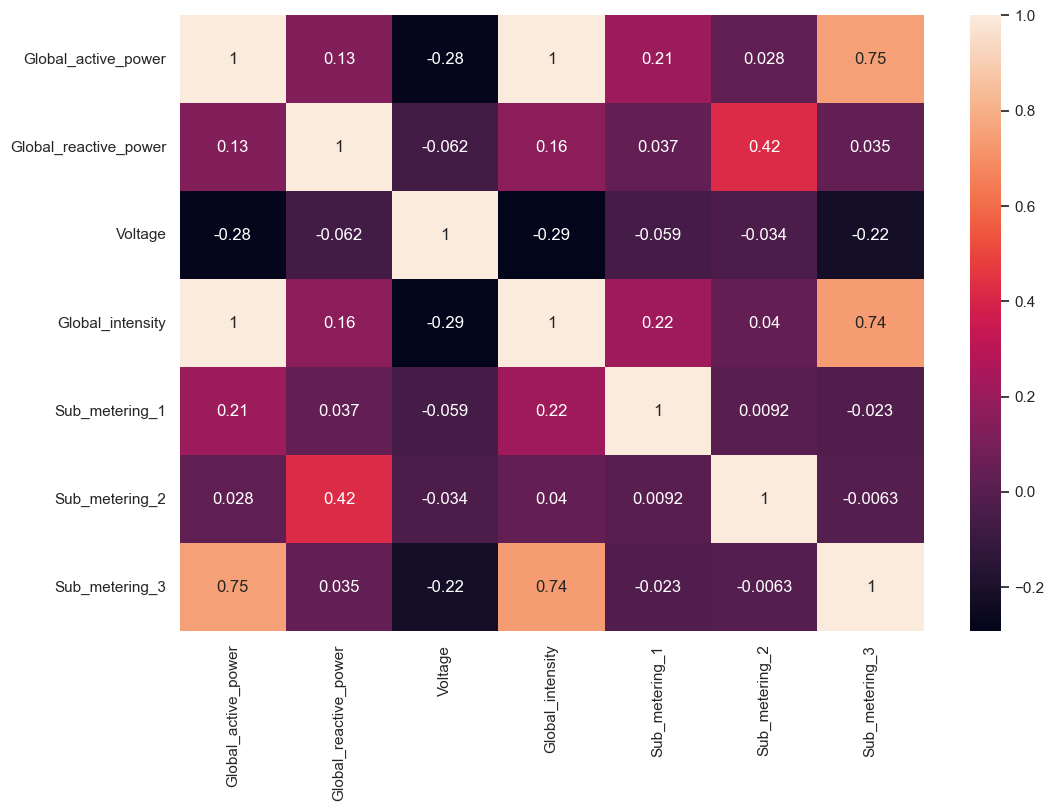

In [1725]:
# crea una matriz de correlacion usando el df2
corr = np.corrcoef(df2_corr.corr())
sns.heatmap(df2_corr.corr(), annot=True)
plt.show()

# EVALUAMOS NUEVAMENTE LOS MODELOS USANDO DF2 SIN LOS VALORES ATIPICOS

# Train Test/Split

In [1726]:
from sklearn.model_selection import train_test_split

cols = ['Global_reactive_power','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3']
X = df2[cols].values
Y = df2['Global_intensity'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 13)

In [1727]:
### variables para guardar información relevante de los modelos
models = {}
coefs = {}

#### Linear Regression

In [1728]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
reg_model.fit(X_train,Y_train)
pred = reg_model.predict(X_test)
models['linear'] = get_metrics(Y_test,pred)
coefs['linear'] = reg_model.coef_

CPU times: total: 125 ms
Wall time: 250 ms


#### Ridge Regression

In [1729]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.linear_model import Ridge

alpha = 0.5
ridge_model = Ridge(alpha=alpha, random_state=13)
ridge_model.fit(X_train,Y_train)
pred = ridge_model.predict(X_test)
models['ridge'] = get_metrics(Y_test,pred)
coefs['ridge'] = ridge_model.coef_

CPU times: total: 125 ms
Wall time: 164 ms


#### Ridge Cross Validation

In [1730]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV
from sklearn.linear_model import RidgeCV

alphas = [0.1, 0.5, 0.8]
ridgeCV_model = RidgeCV(alphas=alphas)
ridgeCV_model.fit(X_train,Y_train)
pred = ridgeCV_model.predict(X_test)
models['ridgeCV'] = get_metrics(Y_test,pred)
coefs['ridgeCV'] = ridgeCV_model.coef_

CPU times: total: 406 ms
Wall time: 637 ms


#### Lasso Regression

In [1731]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
from sklearn.linear_model import Lasso

alpha = 0.5
lasso_model = Lasso(alpha=alpha, random_state=13)
lasso_model.fit(X_train, Y_train)
pred = lasso_model.predict(X_test)
models['lasso'] = get_metrics(Y_test,pred)
coefs['lasso'] = lasso_model.coef_

CPU times: total: 312 ms
Wall time: 279 ms


#### Lasso Cross Validation 

In [1732]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV
from sklearn.linear_model import LassoCV

alphas = [0.1, 0.5, 0.8]
lassoCV_model = LassoCV(alphas=alphas, random_state=13)
lassoCV_model.fit(X_train, Y_train)
pred = lassoCV_model.predict(X_test)
models['lassoCV'] = get_metrics(Y_test,pred)
coefs['lassoCV'] = lassoCV_model.coef_

CPU times: total: 359 ms
Wall time: 999 ms


#### Elastic Net

In [1733]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elastic%20net#sklearn.linear_model.ElasticNet
from sklearn.linear_model import ElasticNet

elastic_model = ElasticNet(random_state=13)
elastic_model.fit(X_train, Y_train)
pred = elastic_model.predict(X_test)
models['elastic'] = get_metrics(Y_test,pred)
coefs['elastic'] = elastic_model.coef_

CPU times: total: 312 ms
Wall time: 357 ms


#### Elastic Net CV

In [1734]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV
from sklearn.linear_model import ElasticNetCV

elasticCV_model = ElasticNetCV(random_state=13)
elasticCV_model.fit(X_train, Y_train)
pred = elasticCV_model.predict(X_test)
models['elasticCV'] = get_metrics(Y_test,pred)
coefs['elasticCV'] = elasticCV_model.coef_

CPU times: total: 1.08 s
Wall time: 2.53 s


#### Decision Tree

In [1735]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=0)
tree_model = tree_model.fit(X_train, Y_train)
pred = tree_model.predict(X_test)
models['decision_tree'] = get_metrics(Y_test,pred)

CPU times: total: 2.02 s
Wall time: 5.2 s


### Verificación de resultados de los modelos 2

In [1736]:
df_coef = pd.DataFrame.from_dict(coefs,orient='index',columns=cols).reset_index()
df_metrics = pd.DataFrame.from_dict(models)

In [1737]:
df_metrics

,linear,ridge,ridgeCV,lasso,lassoCV,elastic,elasticCV,decision_tree
mae,1.23,1.23,1.23,1.29,1.26,1.29,1.25,1.31
mse,3.18,3.18,3.18,3.37,3.31,3.38,3.27,4.47
rmse,1.78,1.78,1.78,1.83,1.82,1.84,1.81,2.11
mape,0.55,0.55,0.55,0.63,0.61,0.63,0.59,0.53
r2,0.63,0.63,0.63,0.61,0.62,0.61,0.62,0.48
ev,0.63,0.63,0.63,0.61,0.62,0.61,0.62,0.48


In [1738]:
df_metrics_2 = df_metrics.copy()

In [1739]:
df_coef

,index,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,linear,3.90,-0.12,0.25,-0.07,0.26
1,ridge,3.90,-0.12,0.25,-0.07,0.26
2,ridgeCV,3.90,-0.12,0.25,-0.07,0.26
3,lasso,0.00,-0.07,0.19,0.00,0.26
4,lassoCV,0.00,-0.11,0.24,0.00,0.26
5,elastic,0.00,-0.06,0.17,0.00,0.25
6,elasticCV,0.48,-0.12,0.25,0.10,0.26


In [1740]:
importance = tree_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.08985
Feature: 1, Score: 0.14749
Feature: 2, Score: 0.07284
Feature: 3, Score: 0.01381
Feature: 4, Score: 0.67602



Los resultados muestran un contraste significativo entre los modelos entrenados con el dataframe1 sin tratamiento de outliers y el dataframe2 con tratamiento de outliers. Vamos a analizarlos en detalle.

1. Sin Tratamiento de Outliers
Métricas (MAE, MSE, RMSE, MAPE): Los errores son extremadamente bajos, lo que indica un ajuste casi perfecto.
R2 y EV: Ambas métricas tienen valores cercanos o iguales a 1.0, lo que sugiere que el modelo explica casi toda la varianza de los datos.
Interpretación:
El desempeño casi perfecto puede indicar que los modelos podriam estar sobreajustados debido a la influencia de los outliers, especialmente si estos están presentes tanto en X como en 𝑦

Esto es particularmente relevante en regresión lineal y sus variantes (Ridge, Lasso, Elastic Net), que son sensibles a valores extremos.

Observaciones:
El árbol de decisión también presenta un rendimiento excelente, pero los árboles son más robustos a outliers, por lo que su desempeño podría reflejar los patrones generales de los datos.

2. Con Tratamiento de Outliers

Métricas de Error (MAE, MSE, RMSE, MAPE): Los errores aumentan significativamente.
R2 y EV: Aunque todavía altos, los valores disminuyen (alrededor de 0.72 para la mayoría de los modelos, y 0.59 para el árbol de decisión).
Interpretación:
El tratamiento de outliers parece haber reducido el ajuste excesivo de los modelos, especialmente en las regresiones lineales.
El rendimiento más modesto sugiere que los modelos ahora están ajustándose a un conjunto de datos más limpio y representativo, eliminando el impacto desproporcionado de valores extremos.

Observaciones:
La disminución en el desempeño del árbol de decisión (R2 = 0.48, EV = 0.48) puede indicar que los valores extremos tenían un impacto significativo en su capacidad de predicción.


* Aunque los modelos sin tratamiento de outliers muestran métricas bien ajustada casi perfectas, podria ser que estan sobreajustados. Los modelos entrenados con el dataframe tratado ofrecen una representación más realista y generalizable de los datos.

* ¿Será necesario escalar los datos?, en caso de utilizar algún método de escalamiento (MinMax, Standard, Robust, otro), ¿mejora o empeora los resultados de los modelos?.

* RESPUESTA: 

El escalado de los datos es una técnica que se utiliza principalmente en modelos que son sensibles a las magnitudes y unidades de las variables predictoras.nLos modelos lineales y sus variantes como Ridge, Lasso y Elastic Net suelen beneficiarse del escalado de los datos porque estos modelos son sensibles a la magnitud de las características. Las variables con escalas grandes pueden dominar el modelo, lo que afecta la capacidad de los coeficientes de regularizar o ajustarse correctamente. Por lo que podria ser un benificio para el modelo que estamos realizando.

* Para responder a la pregunta vamos a utilizar alguno de los metodos de escalados propuestos, en este caso usaremos El MinMaxScaler escala las características para que estén dentro de un rango específico, generalmente entre 0 y 1. Esto es útil cuando tus características no siguen una distribución normal, pero deseas que estén dentro de un rango conocido.

In [1741]:
df2.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
30,16/12/2006,17:54:00,2.72,0.00,235.06,11.60,0.00,0.00,17.00
35,16/12/2006,17:59:00,2.47,0.06,236.94,10.40,0.00,0.00,17.00
36,16/12/2006,18:00:00,2.79,0.18,237.52,11.80,0.00,0.00,18.00
37,16/12/2006,18:01:00,2.62,0.14,238.20,11.00,0.00,0.00,17.00
38,16/12/2006,18:02:00,2.77,0.12,238.28,11.60,0.00,0.00,17.00


In [1743]:
from sklearn.preprocessing import MinMaxScaler

# Crear el objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplicar el escalado MinMax a las variables predictoras
X_scaled = scaler.fit_transform(X)

# Convertir el resultado escalado en un DataFrame con los mismos nombres de columnas
X_scaled_df = pd.DataFrame(X_scaled, columns=['Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'])

# Asegurarnos de que el índice se mantenga igual en X_scaled_df
X_scaled_df.index = df2.index

# Unir la variable objetivo 'Global_intensity' sin escalar
df_scaled = pd.concat([X_scaled_df, df2[['Global_intensity']]], axis=1)

# Ver el dataframe escalado
df_scaled.head()


,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_intensity
30,0.00,0.10,0.00,0.00,0.55,11.60
35,0.15,0.22,0.00,0.00,0.55,10.40
36,0.45,0.26,0.00,0.00,0.58,11.80
37,0.36,0.31,0.00,0.00,0.55,11.00
38,0.30,0.31,0.00,0.00,0.55,11.60


In [1744]:
from sklearn.model_selection import train_test_split

cols = ['Global_reactive_power','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3']
X = df_scaled[cols].values
Y = df_scaled['Global_intensity'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 13)

In [1745]:
### variables para guardar información relevante de los modelos
models = {}
coefs = {}

#### Linear Regression

In [1746]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
reg_model.fit(X_train,Y_train)
pred = reg_model.predict(X_test)
models['linear'] = get_metrics(Y_test,pred)
coefs['linear'] = reg_model.coef_

CPU times: total: 156 ms
Wall time: 237 ms


#### Ridge Regression

In [1779]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.linear_model import Ridge

alpha = 0.5  ## alpha = 0.5
ridge_model = Ridge(alpha=alpha, random_state=13)
ridge_model.fit(X_train,Y_train)
pred = ridge_model.predict(X_test)
models['ridge'] = get_metrics(Y_test,pred)
coefs['ridge'] = ridge_model.coef_

models['ridge'] 

CPU times: total: 62.5 ms
Wall time: 165 ms


{'mae': 1.227,
 'mse': 3.176,
 'rmse': 1.782,
 'mape': 0.548,
 'r2': 0.6334,
 'ev': 0.6334}

#### Ridge Cross Validation

In [1748]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV
from sklearn.linear_model import RidgeCV

alphas = [0.1, 0.5, 0.8]
ridgeCV_model = RidgeCV(alphas=alphas)
ridgeCV_model.fit(X_train,Y_train)
pred = ridgeCV_model.predict(X_test)
models['ridgeCV'] = get_metrics(Y_test,pred)
coefs['ridgeCV'] = ridgeCV_model.coef_

CPU times: total: 234 ms
Wall time: 547 ms


#### Lasso Regression

In [1783]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
from sklearn.linear_model import Lasso


lasso_model = Lasso( random_state=13, alpha= 0.1, fit_intercept= False, max_iter=1000, tol= 0.001)
lasso_model.fit(X_train, Y_train)
pred = lasso_model.predict(X_test)
models['lasso'] = get_metrics(Y_test,pred)
coefs['lasso'] = lasso_model.coef_

models['lasso']

CPU times: total: 281 ms
Wall time: 251 ms


{'mae': 1.263,
 'mse': 4.355,
 'rmse': 2.087,
 'mape': 0.424,
 'r2': 0.4974,
 'ev': 0.5211}

#### Lasso Cross Validation 

In [ ]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV
from sklearn.linear_model import LassoCV

alphas = [0.1, 0.5, 0.8] #el modelo seleccionará automaticamente un conjunto de valores predeterminados para alpha
lassoCV_model = LassoCV(random_state=13,max_iter=1000, tol= 0.0001)
lassoCV_model.fit(X_train, Y_train)
pred = lassoCV_model.predict(X_test)
models['lassoCV'] = get_metrics(Y_test,pred)
coefs['lassoCV'] = lassoCV_model.coef_

models['lassoCV']

CPU times: total: 1.5 s
Wall time: 2.39 s


{'mae': 1.227,
 'mse': 3.176,
 'rmse': 1.782,
 'mape': 0.549,
 'r2': 0.6334,
 'ev': 0.6334}

#### Elastic Net

In [1802]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV
from sklearn.linear_model import ElasticNetCV

elasticCV_model = ElasticNetCV(random_state=13)
elasticCV_model.fit(X_train, Y_train)
pred = elasticCV_model.predict(X_test)
models['elasticCV'] = get_metrics(Y_test,pred)
coefs['elasticCV'] = elasticCV_model.coef_

models['elasticCV'] 

CPU times: total: 953 ms
Wall time: 2.29 s


{'mae': 1.236,
 'mse': 3.189,
 'rmse': 1.786,
 'mape': 0.559,
 'r2': 0.632,
 'ev': 0.632}

#### Elastic Net CV

In [1808]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV
from sklearn.linear_model import ElasticNetCV

elasticCV_model = ElasticNetCV(random_state=13)
elasticCV_model.fit(X_train, Y_train)
pred = elasticCV_model.predict(X_test)
models['elasticCV'] = get_metrics(Y_test,pred)
coefs['elasticCV'] = elasticCV_model.coef_

models['elasticCV']

CPU times: total: 906 ms
Wall time: 2.27 s


{'mae': 1.236,
 'mse': 3.189,
 'rmse': 1.786,
 'mape': 0.559,
 'r2': 0.632,
 'ev': 0.632}

#### Decision Tree

In [1812]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=0, max_depth=10, min_samples_leaf=4, min_samples_split= 10) 
tree_model = tree_model.fit(X_train, Y_train)
pred = tree_model.predict(X_test)
models['decision_tree'] = get_metrics(Y_test,pred)
coefs['decision_tree'] = tree_model.feature_importances_

models['decision_tree']

CPU times: total: 797 ms
Wall time: 2.36 s


{'mae': 1.145,
 'mse': 2.923,
 'rmse': 1.71,
 'mape': 0.485,
 'r2': 0.6626,
 'ev': 0.6626}

In [1753]:
### Verificación de resultados de los modelos 3

In [1768]:
df_coef = pd.DataFrame.from_dict(coefs,orient='index',columns=cols).reset_index()
df_metrics = pd.DataFrame.from_dict(models)

In [1769]:
df_metrics

,linear,ridge,ridgeCV,lasso,lassoCV,elasticCV,decision_tree
mae,1.23,1.23,1.23,1.76,1.42,1.24,1.15
mse,3.18,3.18,3.18,5.20,4.04,3.19,2.92
rmse,1.78,1.78,1.78,2.28,2.01,1.79,1.71
mape,0.55,0.55,0.55,0.98,0.74,0.56,0.48
r2,0.63,0.63,0.63,0.40,0.53,0.63,0.66
ev,0.63,0.63,0.63,0.40,0.53,0.63,0.66


In [1756]:
df_metrics_3 = df_metrics.copy()

In [1757]:
df_coef

,index,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,linear,1.55,-1.78,11.84,-0.14,8.02
1,ridge,1.55,-1.78,11.83,-0.14,8.02
2,ridgeCV,1.55,-1.78,11.84,-0.14,8.02
3,lasso,0.00,-0.00,0.00,0.00,3.96
4,lassoCV,0.00,-0.00,0.00,0.00,6.85
5,elasticCV,1.54,-1.80,9.83,-0.12,7.93
6,decision_tree,0.04,0.02,0.09,0.00,0.84


In [1816]:
# Imprimir los resultados de los modelos
print("Resultado de los modelos sin tratamiento de outliers y sin escalamiento de variables")
df_metrics_1


Resultado de los modelos sin tratamiento de outliers y sin escalamiento de variables


,linear,ridge,ridgeCV,lasso,lassoCV,elastic,elasticCV,decision_tree
mae,1.52,1.52,1.52,1.56,1.56,1.57,1.55,1.61
mse,5.05,5.05,5.05,5.32,5.29,5.33,5.21,7.30
rmse,2.25,2.25,2.25,2.31,2.30,2.31,2.28,2.70
mape,0.56,0.56,0.56,0.63,0.62,0.64,0.61,0.54
r2,0.74,0.74,0.74,0.73,0.73,0.73,0.73,0.63
ev,0.74,0.74,0.74,0.73,0.73,0.73,0.73,0.63


In [1763]:
print("Resultado de los modelos con tratamiento outliers y sin escalamiento de variables")

df_metrics_2


,linear,ridge,ridgeCV,lasso,lassoCV,elastic,elasticCV,decision_tree
mae,1.23,1.23,1.23,1.29,1.26,1.29,1.25,1.31
mse,3.18,3.18,3.18,3.37,3.31,3.38,3.27,4.47
rmse,1.78,1.78,1.78,1.83,1.82,1.84,1.81,2.11
mape,0.55,0.55,0.55,0.63,0.61,0.63,0.59,0.53
r2,0.63,0.63,0.63,0.61,0.62,0.61,0.62,0.48
ev,0.63,0.63,0.63,0.61,0.62,0.61,0.62,0.48


In [1817]:
print("Resultado de los modelos con tratamiento outliers y escalamiento de variables")

df_metrics_3

Resultado de los modelos con tratamiento outliers y escalamiento de variables


,linear,ridge,ridgeCV,lasso,lassoCV,elasticCV,decision_tree
mae,1.23,1.23,1.23,1.76,1.42,1.24,1.15
mse,3.18,3.18,3.18,5.20,4.04,3.19,2.92
rmse,1.78,1.78,1.78,2.28,2.01,1.79,1.71
mape,0.55,0.55,0.55,0.98,0.74,0.56,0.48
r2,0.63,0.63,0.63,0.40,0.53,0.63,0.66
ev,0.63,0.63,0.63,0.40,0.53,0.63,0.66


* El motivo por el cual las métricas de evaluación de los modelos con y sin escalado son prácticamente iguales se debe a las características de los datos. las variables predictoras tienen distribuciones que ya están relativamente balanceadas (es decir, no tienen rangos muy dispares o valores extremos significativos), el impacto del escalado será mínimo o nulo. Esto indica que, las relaciones entre las variables predictoras y la variable objetivo no se ven significativamente alteradas por el rango o la magnitud de los datos. Aqui notamos una mejoria muy leve en los  modelos en general, sin embargo, esto no justuficaria aplicar escalado ya que observamos que los modelos lineales sigue practicamente igual despues de aplicar el metodo de escalamiento MaxMin. 

* ¿Para qué sirve la métrica *explained variance*? El cálculo se encuentra en el código.

La metrica explained variance (varianza explicada) mide qué tan bien un modelo captura la variabilidad presente en la variable objetivo (Y). 
Es una forma de evaluar qué porcentaje de la dispersión de los datos es explicado por el modelo, lo que da una idea de su calidad de ajuste.

Interpretación:
Su valor oscila entre 1 y valores negativos:
1: El modelo explica perfectamente toda la variabilidad en los datos (las predicciones son exactas).
0: El modelo no explica ninguna variabilidad más allá de la media de los datos.
Negativo: Las predicciones son peores que simplemente predecir la media de la variable objetivo.

Funcionalidades:
* - Entender el desempeño del modelo:
Una métrica alta (cercana a 1) indica que el modelo captura bien las relaciones en los datos y predice con precisión.
Un valor bajo sugiere que el modelo no está capturando bien las tendencias y patrones.
* - Comparar modelos:
Es útil para decidir entre varios modelos cuál explica mejor la variabilidad de la variable objetivo.
* - Identificar problemas:
Si el valor es negativo, indica que el modelo está haciendo un trabajo muy deficiente (incluso peor que simplemente predecir la media).

* ¿Qué hiperparámetros de los modelos modificó para llegar a la mejor solución?

Para obtener los mejores hiperamétros utilizamos GridSearchCV, el cual realiza una búsqueda exhaustiva de las mejores combinaciones de hiperparámetros a través de validación cruzada, evaluando el rendimiento del modelo en cada combinación y seleccionando la que dé los mejores resultados.

## RESULTADOS OBTENIDOS: Hiperametros Resultantes con mejor  en modelos

* Riger regresion:{'alpha': 0.1}
* Lasso regresion:{'alpha': 0.1, 'fit_intercept': False, 'max_iter': 1000, 'tol': 0.001}
* Lasso  Cross Validation:{'max_iter': 1000, 'tol': 0.0001}
- Elastic Net: Ninguno ya que los testeados empeoro los resultados del modelo.
- Elastic Net CV: Ninguno ya que los testeados empeoro los resultados del modelo.
* Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

* Nota: Los hiperametros resultantes fueron aplicados en los ultimos modelos implementados en este notebook antes de este bloque de codigo.

## A continuación se detalla el codigo que se utilizo para conseguir los hiperametros ideales.


## Buscando los mejores hiperparametros para riger regresion

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Definir el rango de hiperparámetros a explorar
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],  # Controla la penalización (Regularización L2)
}

# Crear el objeto GridSearchCV con Ridge Regression
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_absolute_error')

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, Y_train)


print(grid_search.best_params_)

Mejores hiperparámetros encontrados:
{'alpha': 0.1}


## Buscando los mejores hiperparametros para Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Definir el rango de hiperparámetros para Lasso
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],  # Regularización L1
    'fit_intercept': [True, False],       # Incluir intercepto en el modelo
    'max_iter': [1000, 5000, 10000],      # Número de iteraciones
    'tol': [0.0001, 0.001, 0.01]          # Tolerancia para convergencia
}

# Crear el objeto GridSearchCV con Lasso
grid_search = GridSearchCV(Lasso(random_state=13), param_grid, cv=5, scoring='neg_mean_absolute_error')

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)


Mejores hiperparámetros encontrados:
{'alpha': 0.1, 'fit_intercept': False, 'max_iter': 1000, 'tol': 0.001}


## Buscando los mejores hiperparametros para Lasso  Cross Validation 

* Lasso  Cross Validation  ya incluye una validación cruzada interna para seleccionar el mejor valor de alpha. Esto significa que LassoCV se encarga automáticamente de realizar la búsqueda de hiperparámetros para alpha durante el ajuste del modelo. Sin embargo otros parametros como max_tier y tol pueden ser ajustados. 

In [1784]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter': [1000, 5000, 10000],      # Número de iteraciones
    'tol': [0.0001, 0.001, 0.01]          # Tolerancia para convergencia
}

grid_search = GridSearchCV(LassoCV(random_state=13), param_grid, cv=5, scoring='neg_mean_absolute_error')

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)


{'max_iter': 1000, 'tol': 0.0001}


## Buscando los mejores hiperparametros para Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Definir el rango de hiperparámetros para la búsqueda
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 10.0],  # Valores posibles de alpha
    'l1_ratio': [0.1, 0.5, 0.7, 1.0]  # Valores posibles de l1_ratio (1 = Lasso, 0 = Ridge)
}

# Inicializar el modelo ElasticNet
elastic_model = ElasticNet(random_state=13)

# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=elastic_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros encontrados: {'alpha': 0.1, 'l1_ratio': 1.0}


* Se testeo el modelo con los hiperparametros 'alpha': 0.1, 'l1_ratio': 1.0 en Elastic Net  pero no favorecio el modelo empeorando su capacidad de predecir.

## Buscando los mejores hiperparametros para Elastic Net CV

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

# Definir el rango de hiperparámetros para la búsqueda
param_grid = {
    'alphas': [[0.1, 0.5, 1.0, 10.0]],  # Valores posibles de alpha (se pasa como lista dentro de una lista)
    'l1_ratio': [0.1, 0.5, 0.7, 1.0],   # Valores posibles de l1_ratio
    'max_iter': [500, 1000, 2000],   # Cambiar el número de iteraciones
    'tol': [0.0001, 0.001, 0.01]     # Cambiar la tolerancia
}

# Inicializar el modelo ElasticNetCV
elasticCV_model = ElasticNetCV(cv=5, random_state=13)

# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=elasticCV_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'alphas': [0.1, 0.5, 1.0, 10.0], 'l1_ratio': 1.0, 'max_iter': 500, 'tol': 0.0001}


* Se testeo el modelo con los hiperparametros'alphas': [0.1, 0.5, 1.0, 10.0], 'l1_ratio': 1.0, 'max_iter': 500, 'tol': 0.0001 en Elastic Net CV  pero no favoreció el modelo empeorando su capacidad de predecir.

## Buscando los mejores hiperparametros para Decision Tree

In [1810]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a probar
param_grid = {
    'max_depth': [3, 5, 10, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras en una hoja
  
}

# Inicializar el modelo DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=13)

# Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, Y_train)


print(grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


  * De los modelos que desarrolló ¿cuál es el que tiene mejor performance respecto a las métricas? interprete los resultados basándose en las métricas.

# Mostrando los resultados de los modelos finales (Despues de limpieza de outliers y ajuste de hiperparametros)

In [1813]:
df_metrics_3

,linear,ridge,ridgeCV,lasso,lassoCV,elasticCV,decision_tree
mae,1.23,1.23,1.23,1.76,1.42,1.24,1.15
mse,3.18,3.18,3.18,5.20,4.04,3.19,2.92
rmse,1.78,1.78,1.78,2.28,2.01,1.79,1.71
mape,0.55,0.55,0.55,0.98,0.74,0.56,0.48
r2,0.63,0.63,0.63,0.40,0.53,0.63,0.66
ev,0.63,0.63,0.63,0.40,0.53,0.63,0.66


Basándonos en las métricas resultantes, el modelo que tiene mejor performance es el modelo de Decision Tree. 

* Error Absoluto Medio (MAE):

Decision Tree tiene el menor MAE con un valor de 1.15, lo que indica que sus predicciones, en promedio, están más cerca de los valores reales comparado con otros modelos.

* Error Cuadrático Medio (MSE):

Decision Tree también tiene el menor MSE (2.92), lo que significa que penaliza menos los errores grandes en comparación con los demás modelos.
Raíz del Error Cuadrático Medio (RMSE):

Este modelo tiene el menor RMSE (1.71), lo que refuerza que sus predicciones son más precisas en términos generales.

* Error Absoluto Porcentual Medio (MAPE):

Decision Tree tiene el menor MAPE con 0.48, indicando que el porcentaje de error en las predicciones es el más bajo.

* Coeficiente de Determinación (R2):

Decision Tree alcanza el mayor R2 (0.66), lo que implica que explica mejor la variabilidad de los datos en comparación con los demás.

* Varianza Explicada (EV):

La métrica de varianza explicada es consistente con el R2 siendo 0.66 para Decision Tree, el mayor valor registrado.

* Interpretación general:

Antes de comenzar la tarea pudimos observar que con las variables predictoras que estaban en el modelo ofrecian una predición muy buena casi perfecta, sin embargo, en la tarea se pidio cambiar estas variables predictoras a (Global_reactive_power, Voltage, Sub_metering_1, Sub_metering_2, Sub_metering_3*) y la variable de salida a (Global Intensity), al hacer este cambio  pudimos observar que ya la relacion no era tan lineal por lo que modelo de Decision Tree supera en todas las métricas clave a los modelos lineales (Linear, Ridge, RidgeCV, Lasso, LassoCV y Elastic Net CV). Esto sugiere que la relación entre las variables no es completamente lineal, y un modelo basado en árboles, con mayor flexibilidad para capturar patrones complejos, se adapta mejor a los datos.

* El modelo Decision Tree es la mejor elección según los resultados presentados depues de realizar la limpieza de outliers y ajuste de hiperparametros.

* ¿Qué diferencias observa al mirar los coeficientes de cada modelo? Interprete cuales son las variables que mejor modelan el problema.

* Imprimimos los coeficientes resultantes para su análisis

In [1814]:
df_coef

,index,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,linear,1.55,-1.78,11.84,-0.14,8.02
1,ridge,1.55,-1.78,11.84,-0.14,8.02
2,ridgeCV,1.55,-1.78,11.84,-0.14,8.02
3,lasso,0.00,-0.00,0.00,0.00,3.96
4,lassoCV,0.00,-0.00,0.00,0.00,6.85
5,elasticCV,1.54,-1.80,9.83,-0.12,7.93
6,decision_tree,0.04,0.02,0.09,0.00,0.84


In [1815]:
importance = tree_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.04304
Feature: 1, Score: 0.01995
Feature: 2, Score: 0.08901
Feature: 3, Score: 0.00499
Feature: 4, Score: 0.84301


* Interpretación de las variables que mejor modelan el problema:

- Sub_metering_1 y Sub_metering_3 son consistentemente las variables más importantes en los modelos lineales, indicando que estas tienen la mayor correlación con la variable objetivo.

- Lasso y ElasticNet resaltan la relevancia de Sub_metering_3, lo que sugiere que, incluso con regularización, esta variable sigue siendo fundamental.

- Global_reactive_power y Voltage tienen una contribución más pequeña en los modelos lineales y tienden a ser ignoradas o minimizadas en los modelos regularizados.

- Decision Tree, aunque no proporciona coeficientes directamente interpretables, sugiere que las contribuciones de las variables están distribuidas de manera diferente, con Sub_metering_3 aún siendo destacada, pero con menor magnitud que en los modelos lineales. Mas abajo se detallan los resultados de decision Tree basado en feature_importances_:

    + Sub_metering_3 tiene una puntuación de 0.84301 (84.3%), lo que significa que es, con mucho, la variable más relevante para predecir la variable objetivo.
    * Sub_metering_1 tiene una importancia del 8.9%, mientras que las demás variables tienen importancias mucho menores:
    * Global_reactive_power: 4.3%
    * Voltage: 1.9%
    * Sub_metering_2: 0.5% (prácticamente irrelevante).



* En resumen, Sub_metering_3 parece ser la variable más relevante y consistente para modelar el problema, seguida por Sub_metering_1 en los modelos lineales. Otros factores como Global_reactive_power y Voltage tienen una menor influencia. Esto podría reflejar relaciones no lineales o redundancias que son capturadas mejor por modelos como ElasticNet o Decision Tree.